<a href="https://colab.research.google.com/github/vitorscience/Data-Science/blob/main/%5BPROJETO%5D_Previs%C3%A3o_de_Demanda_com_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 4.0**


---

<center><img alt="Vaga" width="50%" src="https://static.cordonbleu.edu/Files/MediaFile//76023.jpg?v=385198515"></center>

Este projeto refere-se a uma vaga de emprego real, disponibilizada em 2021, para cientistas de dados. Trata-se de uma oportunidade em uma empresa do setor de vinhos, que busca desenvolver um software de gerenciamento de inventário com o apoio de Machine Learning. O objetivo do software é prever as necessidades de reposição de estoque com base em dados históricos de vendas, considerando as particularidades da indústria de vinhos.  

### Requisitos gerais da vaga:  
- Análise de grandes volumes de dados complexos para identificar padrões significativos.  
- Capacidade de realizar modelagem estatística e desenvolver modelos preditivos.  
- Conhecimento em algoritmos de Machine Learning e no treinamento de modelos de ML.  

Para mais informações, confira a [vaga no LinkedIn](https://www.linkedin.com/jobs/view/2435754417/).

Os dados fornecidos são um detalhamento de vendas e estão disponíveis no GitHub:  

- [Dados sobre os produtos](https://raw.githubusercontent.com/rafaelnduarte/sigmoidal_data/master/products.csv)  
- [Dados de vendas](https://raw.githubusercontent.com/rafaelnduarte/sigmoidal_data/master/sales-clean.csv)

In [1]:
#Instalando bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import prophet

 primeira base de dados é, basicamente, um histórico de tipos de vinhos, contendo informações como o nome, o produtor, a região, o tipo do vinho e o preço.

In [2]:
# carregando os dados dos produtos
df = pd.read_csv('https://raw.githubusercontent.com/rafaelnduarte/sigmoidal_data/master/products.csv')
print (df.shape)
df.head()

(219, 9)


,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd
0,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,NV,sparkling,339.60,58.75
1,2,Philipponnat Royale Reserve Rosé,Philipponat,France,Champagne,NV,rose sparkling,489.00,84.60
2,3,Philipponnat Cuvée 1522 Grand Cru Extra Brut,Philipponat,France,Champagne,2009,sparkling,789.00,136.51
3,4,Philipponnat Cuvée 1522 1er Cru Rosé,Philipponat,France,Champagne,2008,rose sparkling,899.40,155.61
4,5,Philipponnat Clos Des Goisses Brut,Philipponat,France,Champagne,2009,sparkling,"1,548.00",267.82


### Dicionário de Variáveis

* item_id = Número de identificação do item
* name = Nome do vinho
* producer = Nome do Produtor do vinho
* country = País de origem do vinho
* vintage = Safra do vinho
* kind = Tipo do vinho
* price_brl = Preço brl
* price_usd = Preço usd

# A análise exploratória

É uma etapa crucial em qualquer projeto de ciência de dados, pois permite obter uma compreensão profunda dos dados disponíveis. Nessa fase, os dados são examinados com o objetivo de identificar padrões, tendências e possíveis inconsistências que possam impactar o projeto.

Além disso, é durante essa análise que problemas de negócio específicos são investigados, permitindo alinhar os dados com os objetivos estratégicos da empresa. Também são exploradas questões determinísticas, como a presença de valores ausentes, outliers e a consistência das variáveis, garantindo que a base de dados esteja preparada para as etapas subsequentes do projeto, como modelagem e previsão.

Essa etapa fornece insights valiosos e estabelece uma base sólida para a criação de modelos preditivos e a tomada de decisões baseadas em dados.

In [3]:
df.vintage = df.vintage.replace("NV","0")
df.vintage = pd.to_numeric(df.vintage)

In [4]:
df = df.replace(",","", regex=True)

In [5]:
df.price_brl = pd.to_numeric(df.price_brl)

In [6]:
df.price_brl

,price_brl
0,339.6
1,489.0
2,789.0
3,899.4
4,1548.0
...,...
214,235.2
215,699.0
216,539.4
217,599.4


In [7]:
name_price = df.groupby("name")["price_brl"].max().sort_values(ascending=False)
top_five_wines = name_price.head()
top_five_wines

,price_brl
name,
Domaine Ponsot Clos de La Roche Grand Cru Cuvee Vieilles Vignes - Magnum,10992.0
Latour,9594.0
Château Pavie,5999.4
Domaine Ponsot Clos de La Roche Grand Cru Cuvee Vieilles Vignes,5994.0
Aalto PS - 3.0L (Double Magnum),4992.0


In [8]:
qtd_pais = df.groupby('country')['item_id'].count().sort_values(ascending=False)
qtd_pais

,item_id
country,
France,154
Italy,23
Spain,18
Portugal,15
Argentina,8
Chile,1


Conforme os dados disponíveis, o país com a maior variedade de vinhos é a França, que conta com 154 tipos diferentes de vinhos registrados na base.

In [9]:
mean_kin_price = df.groupby("kind")["price_brl"].mean().sort_values(ascending=False)
mean_kin_price

,price_brl
kind,
red,1230.880303
sparkling,709.680000
white,579.379710
rose sparkling,487.600000
rose,179.040000


Os vinhos categorizados como "vermelho" possuem o maior preço médio entre todas as categorias presentes na base de dados.

In [10]:
mean_producer_price = df.groupby('producer')['price_brl'].mean().sort_values(ascending=False)
mean_producer_price.head()

,price_brl
producer,
Chateau Latour,5126.0
Domaine Ponsot,4057.5
Viñedo Chadwick,3594.0
Domaine Fourrier,3390.0
Domaine Dujac,3294.0


O produtor **"Chateau Latour"** possui a maior média de preço por item, com um valor de **R$ 5.126,00**.

In [11]:
df.vintage.unique()

array([   0, 2009, 2008, 2013, 2019, 2018, 2014, 2016, 2015, 2017, 2003,
       2004, 2007, 2011, 2012, 2002, 2010])

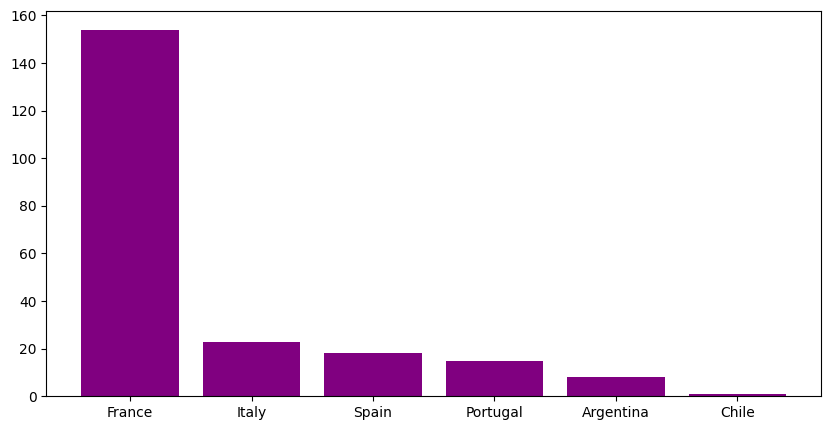

In [12]:
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(qtd_pais.index, qtd_pais.values, color='purple')

plt.show()

In [13]:
df

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd
0,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75
1,2,Philipponnat Royale Reserve Rosé,Philipponat,France,Champagne,0,rose sparkling,489.0,84.60
2,3,Philipponnat Cuvée 1522 Grand Cru Extra Brut,Philipponat,France,Champagne,2009,sparkling,789.0,136.51
3,4,Philipponnat Cuvée 1522 1er Cru Rosé,Philipponat,France,Champagne,2008,rose sparkling,899.4,155.61
4,5,Philipponnat Clos Des Goisses Brut,Philipponat,France,Champagne,2009,sparkling,1548.0,267.82
...,...,...,...,...,...,...,...,...,...
214,215,Achaval-Ferrer Quimera,Achaval Ferrer,Argentina,Mendoza,2015,red,235.2,40.69
215,216,Achaval-Ferrer Finca Altamira,Achaval Ferrer,Argentina,Mendoza,2014,red,699.0,120.93
216,217,Achaval-Ferrer Finca Bella Vista,Achaval Ferrer,Argentina,Mendoza,2014,red,539.4,93.32
217,218,Achaval-Ferrer Finca Mirador,Achaval Ferrer,Argentina,Mendoza,2014,red,599.4,103.70


In [14]:
df.item_id = df.item_id.astype(str)

A segunda base de dados consiste, basicamente, em informações sobre a quantidade de vendas realizadas. Essa base será concatenada com a anterior por meio da coluna **"item"**. Dessa forma, será possível identificar e analisar a quantidade de cada item vendido, permitindo cruzar informações como preço, tipo de vinho e região com os dados de vendas. Isso oferece uma visão mais detalhada e estratégica sobre o desempenho de cada produto no mercado.

In [15]:
store = pd.read_csv('https://raw.githubusercontent.com/rafaelnduarte/sigmoidal_data/master/sales-clean.csv')


store.rename(columns= {'item': 'item_id'}, inplace=True)
store.item_id = store.item_id.astype(str)

store = df.merge(store, on='item_id', how='right')

store['date'] = pd.to_datetime(store['date'], format="mixed")
store.index = store['date']
store.drop('date', axis=1, inplace=True)

print(store.shape)
store.head()

(720071, 11)


,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd,store,sales
date,,,,,,,,,,,
2018-01-01,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,13
2018-01-02,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,11
2018-01-03,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,14
2018-01-04,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,13
2018-01-05,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,10


<Axes: title={'center': 'Faturamento por tipo de vinho'}, xlabel='kind'>

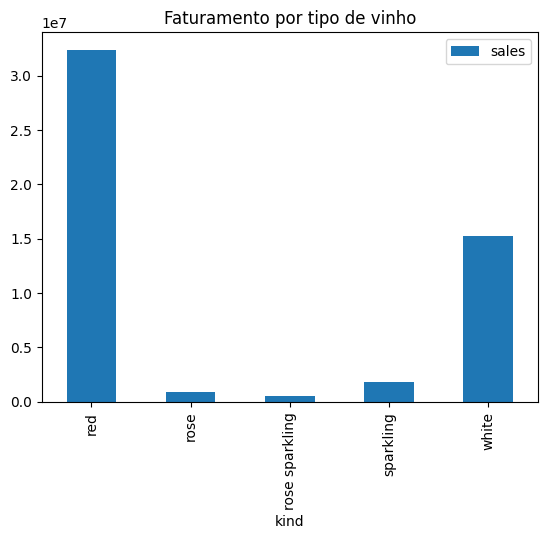

In [16]:
store['perco_brl'] = store['price_brl'] * store['sales']
faturamento_kind = store.groupby('kind').agg({'sales': 'sum', 'perco_brl': 'sum'}).reset_index()
faturamento_kind.plot(kind='bar', x='kind', y='sales', title='Faturamento por tipo de vinho')

<Axes: title={'center': 'Faturamento por região'}, xlabel='region'>

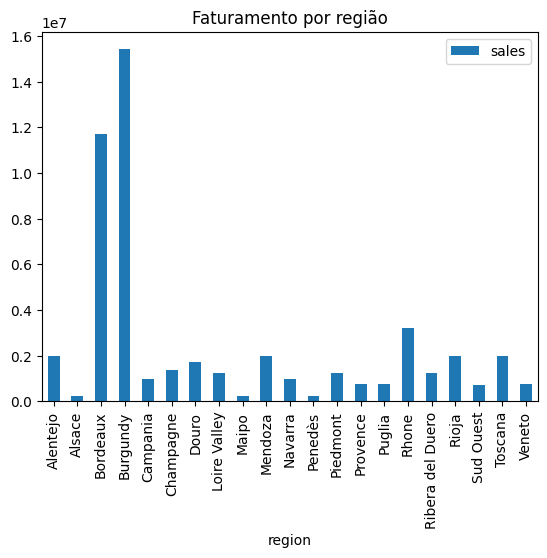

In [17]:
faturamento_region = store.groupby('region').agg({'sales': 'sum', 'perco_brl': 'sum'}).reset_index()
faturamento_region.plot(kind='bar', x='region', y='sales', title='Faturamento por região')

Os vinhos de categoria "*Branco*" e categoria "*Vermelho*", foram os vinhos que realizaram maior faturamento

In [18]:
store.isnull().sum()

,0
item_id,0
name,0
producer,0
country,0
region,0
vintage,0
kind,0
price_brl,0
price_usd,0
store,0


In [19]:
#Expurgando o ano 2016 da base de dados, para melhoria na previsão
store["month"] = store.index.month
store["year"] = store.index.year
store = store[~(store.year == 2016)]

In [20]:
store.sales = store.sales.astype(int)

<Axes: xlabel='kind'>

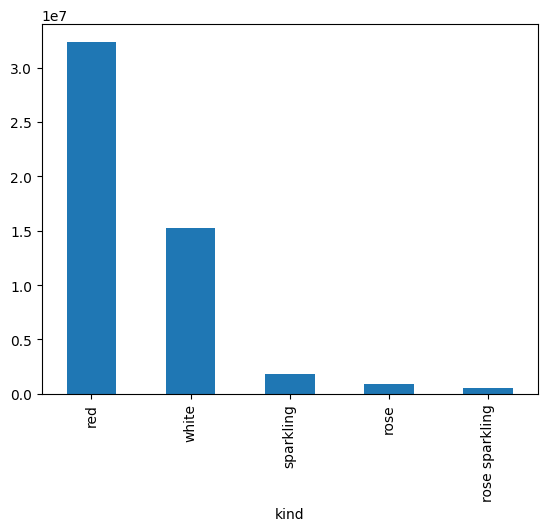

In [21]:
store.groupby('kind')['sales'].sum().sort_values(ascending=False).plot(kind='bar')

Conforme o grafico acima o Vinho "Vermelho" é o mais vendido

In [22]:
df_prev = store.groupby('date')['sales'].sum().reset_index()


In [23]:
df_prev.index = pd.to_datetime(df_prev.date, format='%Y-%m-%d')
df_prev.drop('date', axis=1, inplace=True)
df_prev

,sales
date,
2018-01-01,43432
2018-01-02,43181
2018-01-03,43298
2018-01-04,42216
2018-01-05,42001
...,...
2020-12-27,45931
2020-12-28,42754
2020-12-29,43804


In [24]:
df_prev.reset_index(inplace=True)

In [25]:
df_prev.columns =["ds" ,"y"]

In [26]:
df_prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1096 non-null   datetime64[ns]
 1   y       1096 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 17.2 KB


In [27]:
!pip install prophet -q

In [28]:
import prophet
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller


In [29]:
# importanto o pacote
from statsmodels.tsa.stattools import adfuller
# extraindo os valores
X = df_prev.y

# aplicando o ADF e imprimindo os resultados.
result = adfuller(X)
print('Augmented Dickey–Fuller')
print('Statistical Test: {:.4f}'.format(result[0]))
print('P Value: {:.10f}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
	print('\t{}: {:.4f}'.format(key, value))

Augmented Dickey–Fuller
Statistical Test: -2.3601
P Value: 0.1533303754
Critical Values:
	1%: -3.4365
	5%: -2.8642
	10%: -2.5682


Com base no valor do p-value sendo maior que 0,05, conclui-se que a hipótese nula do teste de estacionariedade não pode ser rejeitada. Isso indica que a série temporal analisada não é estacionária, ou seja, suas propriedades estatísticas, como média e variância, podem variar ao longo do tempo.

Detalhando os resultados:

* Statistical Test: -2.3601
* P-value: 0.1533303754
* Critical Values:
  1%: -3.4365
  5%: -2.8642
  10%: -2.5682


Como o valor calculado do teste estatístico (-2.3601) não ultrapassa o valor crítico de 5% (-2.8642) e o p-value está acima do limite de significância de 0,05, a série não apresenta evidências suficientes para ser considerada estacionária.

Previsão com 30 dias de para treinamento

In [30]:
prediction = 30
train = df_prev[:-prediction]
train.tail()


,ds,y
1061,2020-11-27,48274
1062,2020-11-28,48447
1063,2020-11-29,48886
1064,2020-11-30,44065
1065,2020-12-01,44322


In [31]:
m = Prophet()
m.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphtc94cx3/uwgotb6n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphtc94cx3/1m_uppzd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56474', 'data', 'file=/tmp/tmphtc94cx3/uwgotb6n.json', 'init=/tmp/tmphtc94cx3/1m_uppzd.json', 'output', 'file=/tmp/tmphtc94cx3/prophet_modelu2lyq94v/prophet_model-20241231155756.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [32]:
future = m.make_future_dataframe(periods=prediction, freq='D')

In [33]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1091,2020-12-27,44583.120290,42908.095627,46118.782282
1092,2020-12-28,44374.625910,42758.116114,45787.275036
1093,2020-12-29,44665.178741,43119.867274,46320.397161
1094,2020-12-30,45011.836349,43467.835334,46560.331889
1095,2020-12-31,45498.159329,43908.796729,47005.565683



Com a previsão gerada pelo modelo forecast, é possível compreender a distribuição do volume previsto ao longo do tempo.

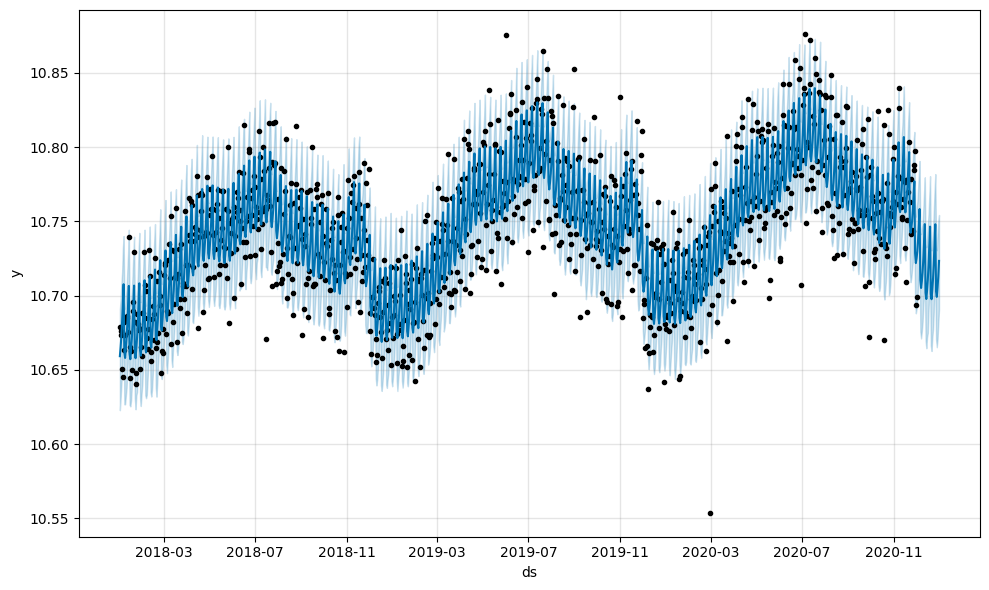

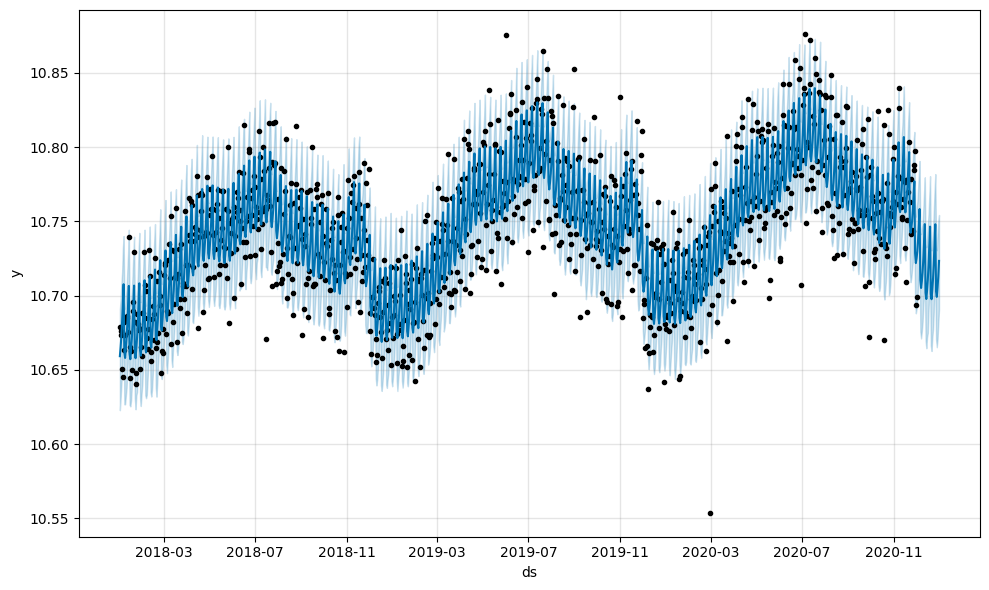

In [61]:
m.plot(forecast)

O gráfico abaixo apresenta a análise dos componentes do modelo Prophet, permitindo a visualização de:

* Tendência
* Sazonalidade semanal
* Sazonalidade anual

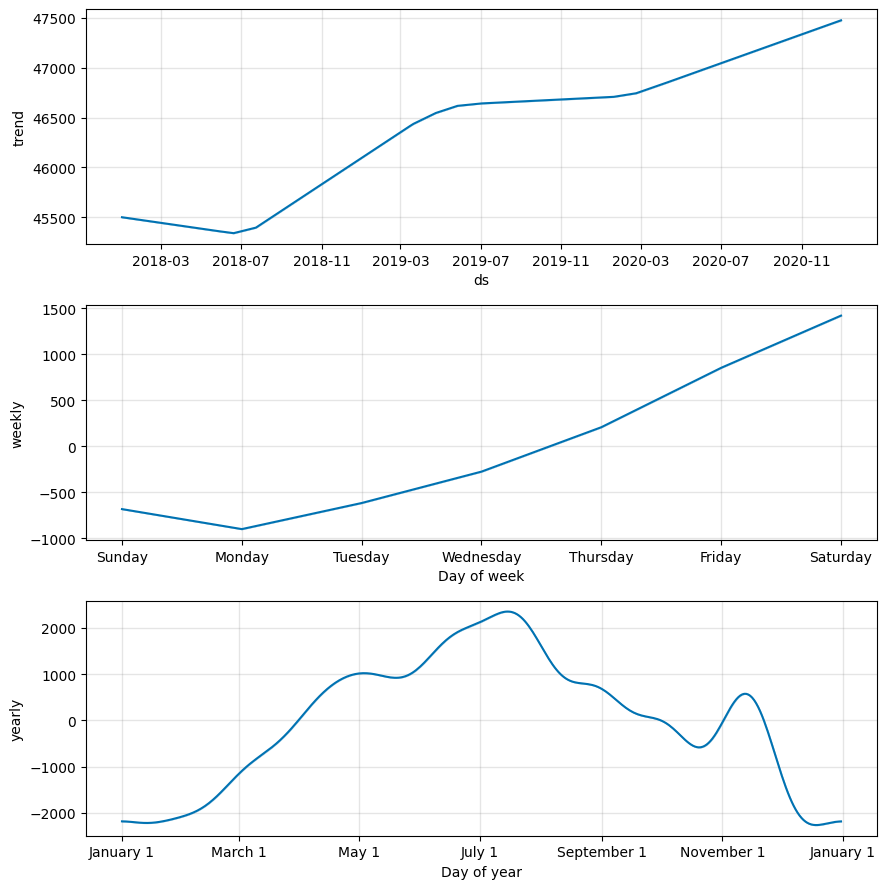

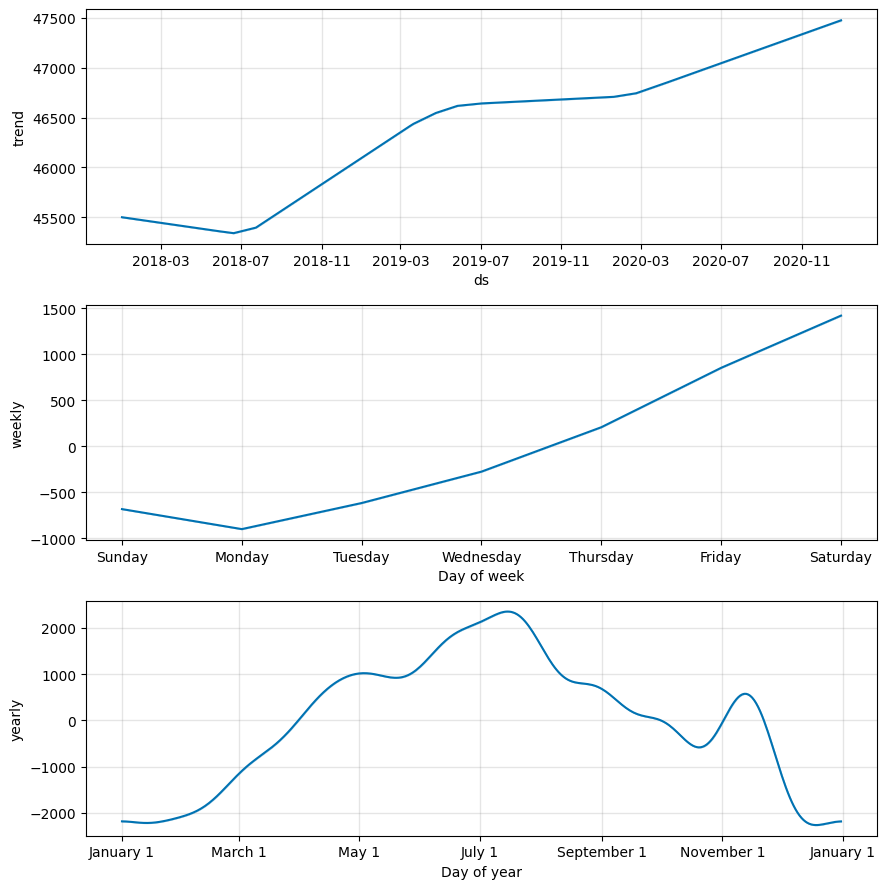

In [35]:
m.plot_components(forecast)

In [36]:
cpm = forecast.set_index('ds')[['yhat', 'yhat_lower',
                                'yhat_upper']].join(df_prev.set_index('ds'))

In [37]:
cpm["desvio"] = ((cpm.yhat - cpm.y)/cpm.y)*100

In [38]:
cpm.tail()

,yhat,yhat_lower,yhat_upper,y,desvio
ds,,,,,
2020-12-27,44583.120290,42908.095627,46118.782282,45931,-2.934575
2020-12-28,44374.625910,42758.116114,45787.275036,42754,3.790583
2020-12-29,44665.178741,43119.867274,46320.397161,43804,1.965982
2020-12-30,45011.836349,43467.835334,46560.331889,44546,1.045742
2020-12-31,45498.159329,43908.796729,47005.565683,44592,2.032112


In [39]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


In [40]:
# Extraindo os valores reais e previstos
y_real = cpm['y']
y_pred = cpm['yhat']

# Calculando as métricas
r2 = r2_score(y_real, y_pred)
mae = mean_absolute_error(y_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_real, y_pred))
desvio = (y_real - y_pred)/y_real
desvio = desvio.mean()

# Exibindo os resultados
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Desvio: {desvio*100:.4f}%")

R²: 0.6739
MAE: 941.7070
RMSE: 1219.4619
Desvio: -0.1041%


Os indicadores apresentados representam a avaliação do desempenho do modelo:  

- **R² (Coeficiente de Determinação):** 0.6739  
  Indica que aproximadamente 67,39% da variação nos dados é explicada pelo modelo.  

- **MAE (Erro Médio Absoluto):** 941.7070  
  Representa o erro médio absoluto entre os valores previstos pelo modelo e os valores reais.  

- **RMSE (Raiz do Erro Quadrático Médio):** 1219.4619  
  Mede a magnitude média dos erros, dando maior peso a erros maiores.  

- **Desvio:** -0.1041%  
  Representa o desvio percentual médio entre os valores previstos e os reais, indicando que, em média, o modelo subestima os valores em 0,1041%.  

<Axes: xlabel='ds'>

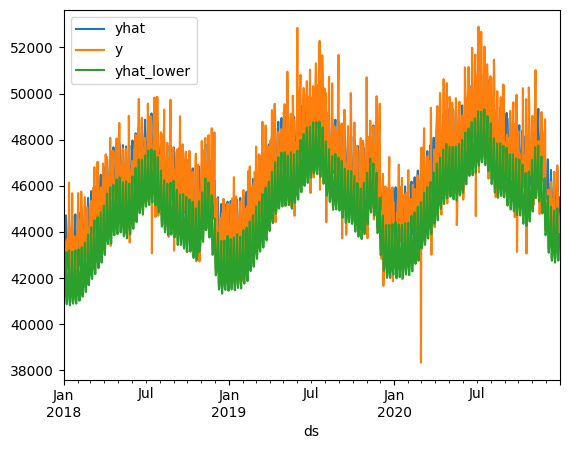

In [41]:
cpm[["yhat" ,"y", "yhat_lower"]].plot()

In [42]:
# preparando os dados
df_prev.index = pd.to_datetime(df_prev['ds'], format="%Y-%m-%d")
df_prev.drop('ds', axis=1, inplace=True)
df_prev.head()

,y
ds,
2018-01-01,43432
2018-01-02,43181
2018-01-03,43298
2018-01-04,42216
2018-01-05,42001


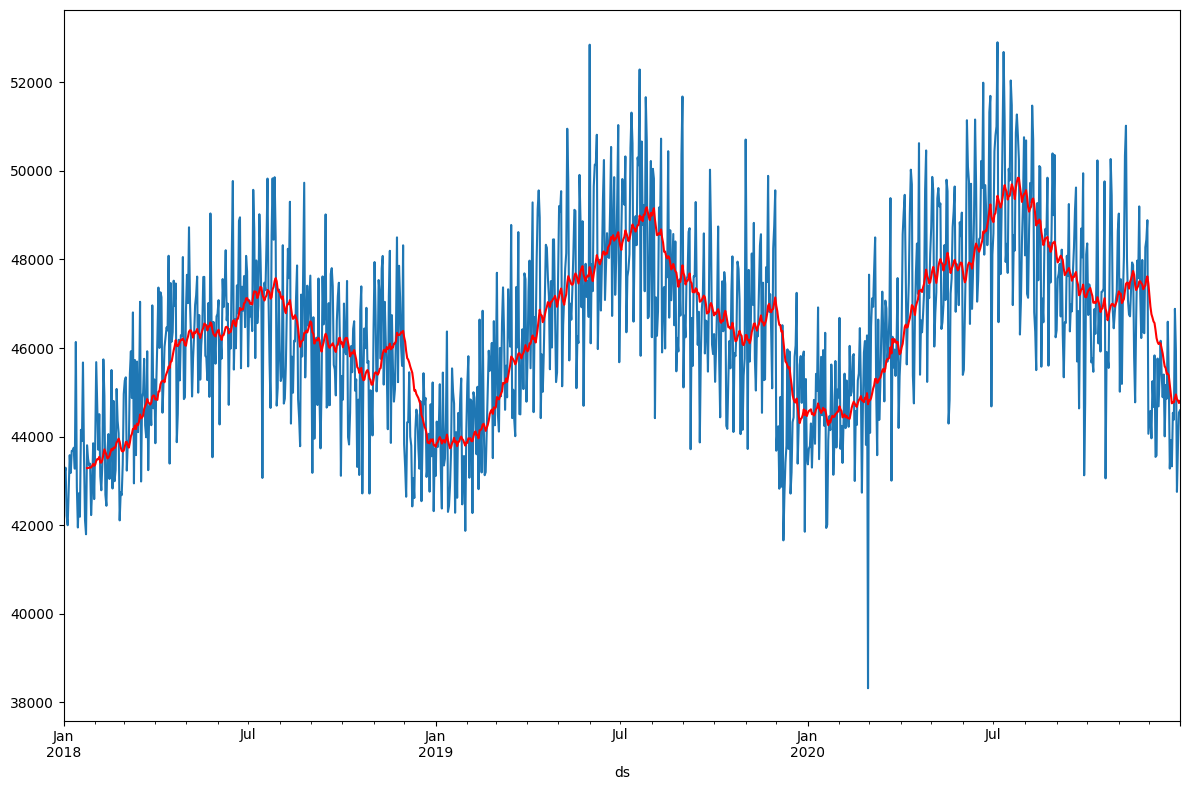

In [43]:
# checando o plot original
ma = df_prev.rolling(24).mean()

fig, ax = plt.subplots(figsize=(12,8))
df_prev.plot(ax=ax, legend=False)
ma.plot(ax=ax, color='r', legend=False)
plt.tight_layout();

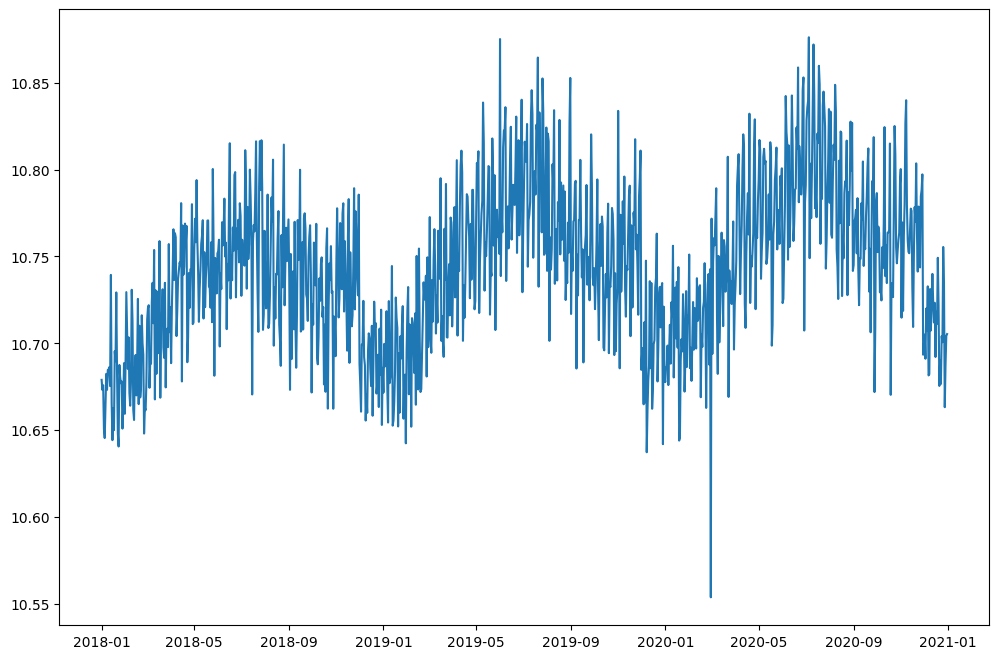

In [44]:
# aplicando o log
fig, ax = plt.subplots(figsize=(12,8))
ts_log = np.log(df_prev)
plt.plot(ts_log);

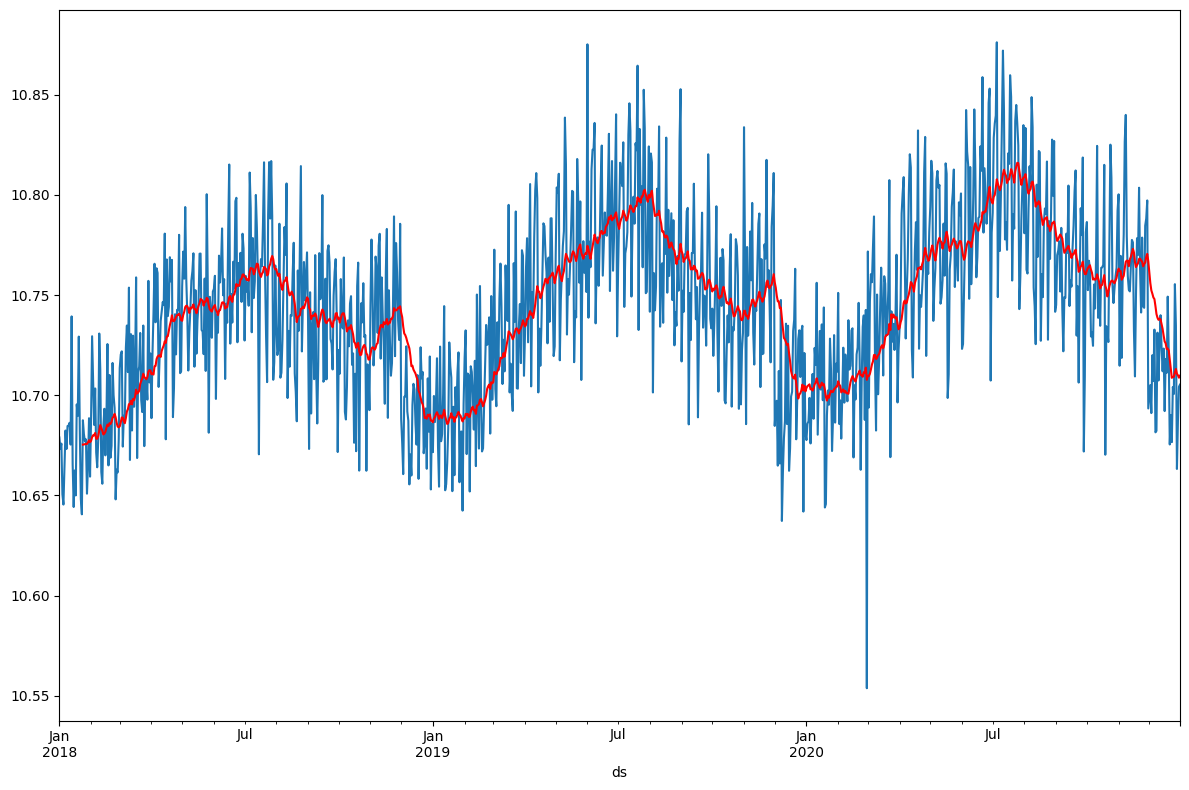

In [45]:
# aplicando o log
df_log = np.log(df_prev)
ma_log = df_log.rolling(24).mean()

fig, ax = plt.subplots(figsize=(12,8))
df_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, color='r', legend=False)
plt.tight_layout()

Para transformar a série em estacionária, é necessário aplicar o logaritmo, pois essa transformação ajuda a reduzir a amplitude das variações e estabilizar a variância dos dados ao longo do tempo. Além disso, outras técnicas podem ser utilizadas em conjunto, como a diferenciação (differencing) para remover tendências e ajustar sazonalidades presentes na série. Após a aplicação dessas transformações, é importante reavaliar a estacionariedade da série com testes estatísticos, como o teste de Dickey-Fuller Aumentado (ADF), para verificar se a série atende aos requisitos necessários para os métodos de modelagem baseados em séries estacionárias.

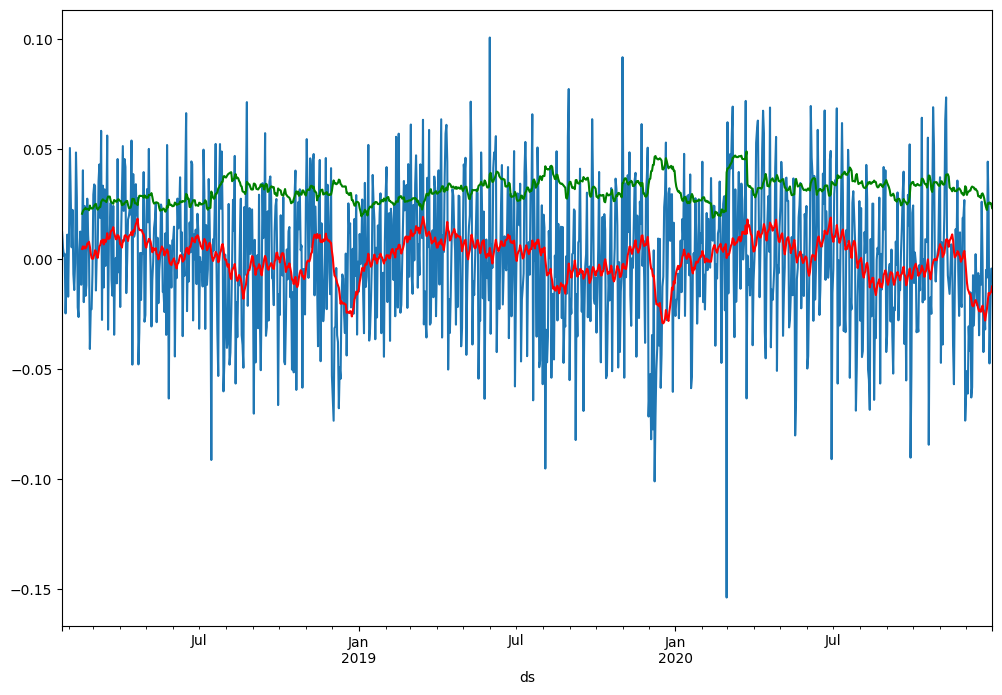

In [46]:
# subtraindo a média do log nos dados
df_sub = (df_log - ma_log).dropna()
ma_sub = df_sub.rolling(24).mean()
std_sub = df_sub.rolling(24).std()

fig, ax = plt.subplots(figsize=(12,8))
df_sub.plot(ax=ax, legend=False)
ma_sub.plot(ax=ax, color='r', legend=False)
std_sub.plot(ax=ax, color='g', legend=False)
plt.show();

In [47]:
# repetindo o ADF
X_sub = df_sub.y.values

# aplicando o ADF e imprimindo os resultados
result_sub = adfuller(X_sub)
print('Augmented Dickey–Fuller')
print('Statistical Test: {:.4f}'.format(result_sub[0]))
print('P Value: {:.10f}'.format(result_sub[1]))
print('Critical Values:')
for key, value in result_sub[4].items():
	print('\t{}: {:.4f}'.format(key, value))

Augmented Dickey–Fuller
Statistical Test: -5.6436
P Value: 0.0000010231
Critical Values:
	1%: -3.4366
	5%: -2.8643
	10%: -2.5682


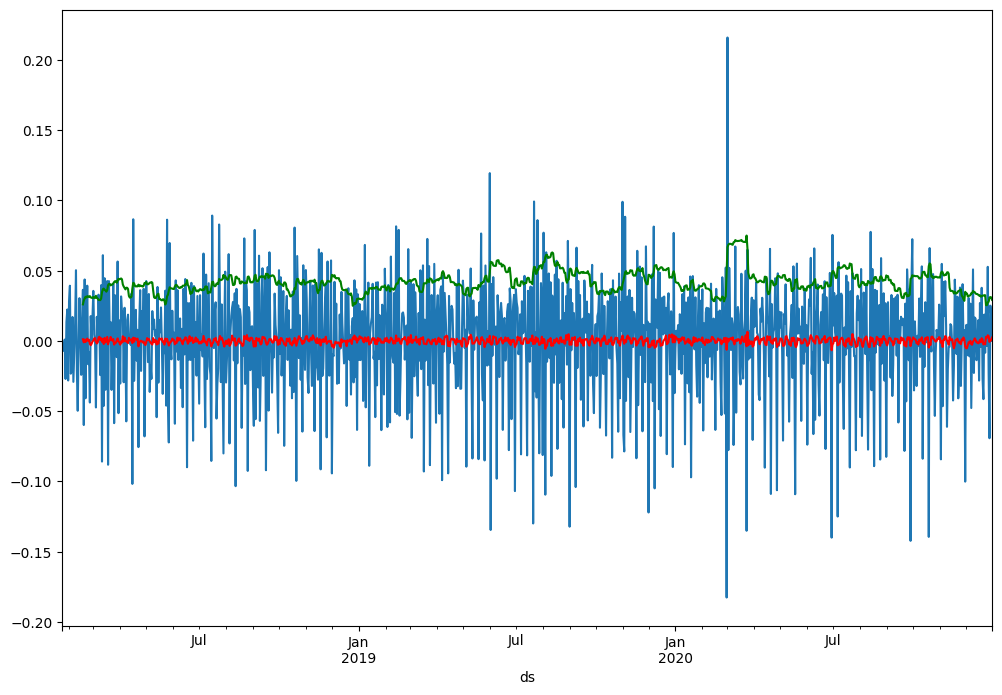

Augmented Dickey–Fuller
Statistical Test: -5.6436
P Value: 0.0000010231
Critical Values:
	1%: -3.4366
	5%: -2.8643
	10%: -2.5682


In [48]:
# aplicando a diferenciação
df_diff = df_sub.diff(1)
ma_diff = df_diff.rolling(24).mean()
std_diff = df_diff.rolling(24).std()

fig, ax = plt.subplots(figsize=(12,8))
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, color='r', legend=False)
std_diff.plot(ax=ax, color='g', legend=False)
plt.show()

# extraindo os valores
X_diff = df_diff.y.dropna().values

# aplicando o ADF e imprimindo os resultados
result_diff = adfuller(X_diff)
print('Augmented Dickey–Fuller')
print('Statistical Test: {:.4f}'.format(result_sub[0]))
print('P Value: {:.10f}'.format(result_sub[1]))
print('Critical Values:')
for key, value in result_sub[4].items():
	print('\t{}: {:.4f}'.format(key, value))

In [49]:

# transformando no formato do Prophet
df_log.reset_index(inplace=True)


In [50]:
prediction_size = 30
train_df = df_log[:-prediction_size]

In [51]:
m = prophet.Prophet()
m.fit(train_df)
# fazer previsões
future = m.make_future_dataframe(periods=prediction_size)
forecast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphtc94cx3/gxhzn0f6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphtc94cx3/cmjhbjo_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89757', 'data', 'file=/tmp/tmphtc94cx3/gxhzn0f6.json', 'init=/tmp/tmphtc94cx3/cmjhbjo_.json', 'output', 'file=/tmp/tmphtc94cx3/prophet_model76ijng6d/prophet_model-20241231155813.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:58:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:58:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


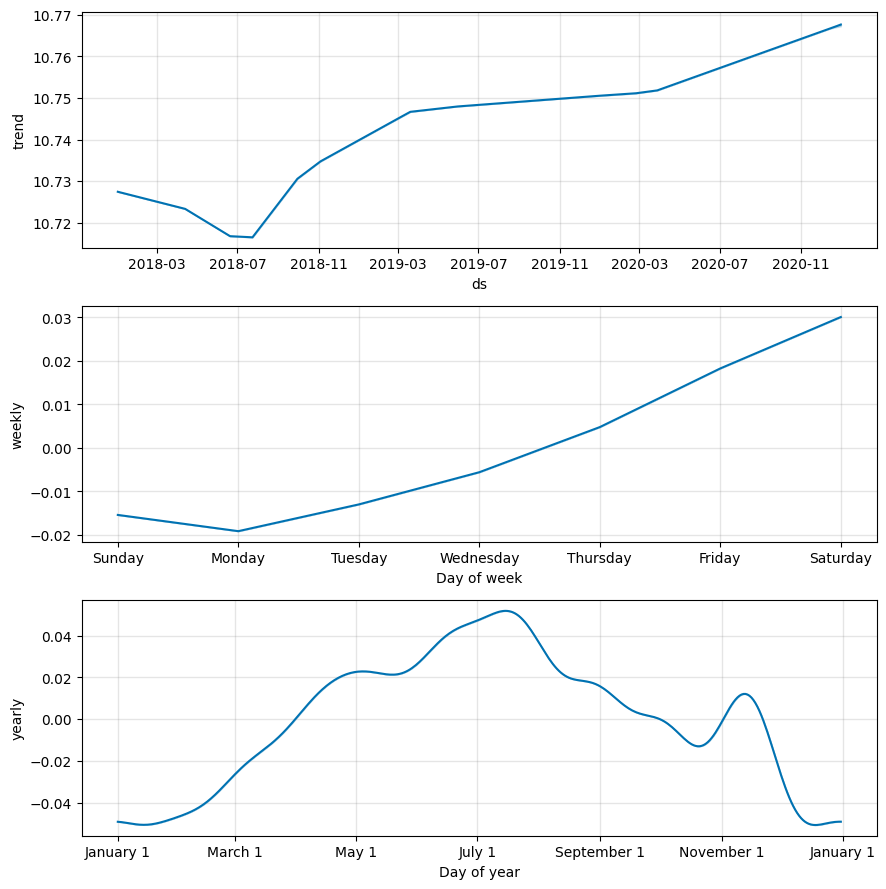

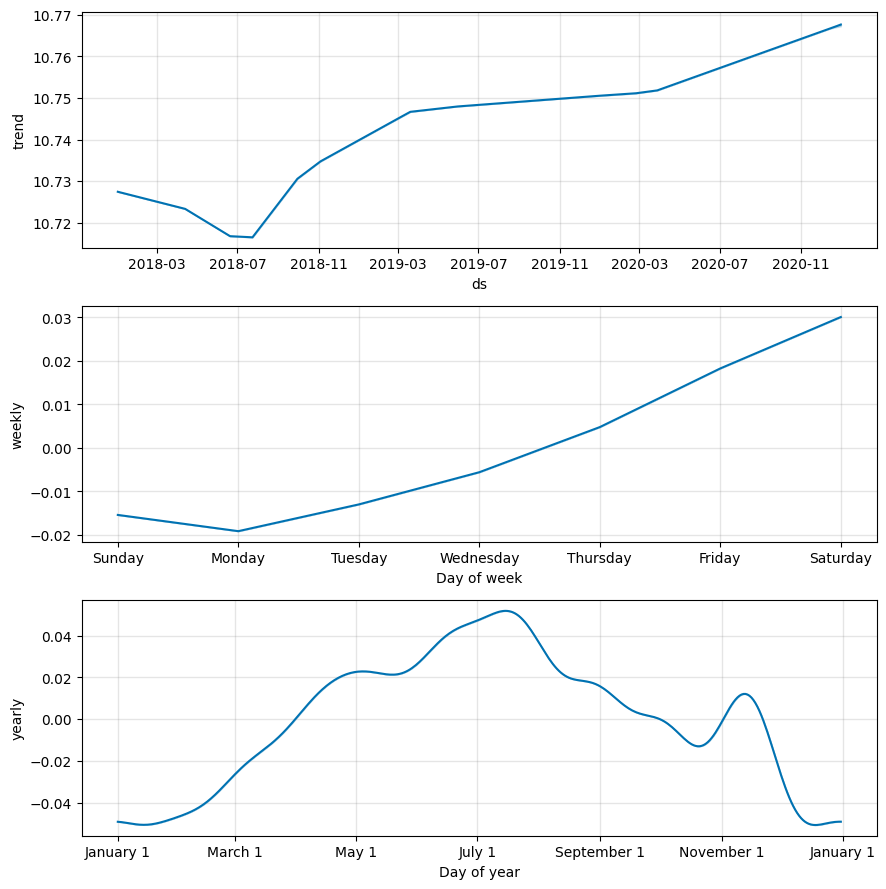

In [52]:
m.plot_components(forecast)

In [53]:
# criando um dataset completo
df_final = forecast[['ds', 'yhat']]
df_final.head()

,ds,yhat
0,2018-01-01,10.659210
1,2018-01-02,10.665254
2,2018-01-03,10.672520
3,2018-01-04,10.682736
4,2018-01-05,10.696041


In [54]:
# visualizing the preditctions as tables
df_final['AmountSpentLog'] = df_log['y']
df_final.head()

<ipython-input-54-e93109ce7770>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['AmountSpentLog'] = df_log['y']


,ds,yhat,AmountSpentLog
0,2018-01-01,10.659210,10.678952
1,2018-01-02,10.665254,10.673156
2,2018-01-03,10.672520,10.675862
3,2018-01-04,10.682736,10.650555
4,2018-01-05,10.696041,10.645449


In [55]:
# getting the values back to their original scale
df_final['AmountSpent'] = np.exp(df_final['AmountSpentLog'].values)
df_final['AmountSpentPred'] = np.exp(df_final['yhat'].values)
df_final.head(10)

<ipython-input-55-2ea16519590a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['AmountSpent'] = np.exp(df_final['AmountSpentLog'].values)
<ipython-input-55-2ea16519590a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['AmountSpentPred'] = np.exp(df_final['yhat'].values)


,ds,yhat,AmountSpentLog,AmountSpent,AmountSpentPred
0,2018-01-01,10.659210,10.678952,43432.0,42582.999945
1,2018-01-02,10.665254,10.673156,43181.0,42841.118768
2,2018-01-03,10.672520,10.675862,43298.0,43153.570560
3,2018-01-04,10.682736,10.650555,42216.0,43596.665314
4,2018-01-05,10.696041,10.645449,42001.0,44180.606047
5,2018-01-06,10.707670,10.663522,42767.0,44697.393201
6,2018-01-07,10.661965,10.682400,43582.0,42700.479017
7,2018-01-08,10.658034,10.673179,43182.0,42532.940498
8,2018-01-09,10.663997,10.684646,43680.0,42787.301003
9,2018-01-10,10.671227,10.684783,43686.0,43097.793578


In [62]:
# Assuming 'AmountSpent' is the actual value and 'AmountSpentPred' is the predicted value
y_true = df_final['AmountSpent'].values
y_pred = df_final['AmountSpentPred'].values

# Calculate MAE
mae = mean_absolute_error(y_true, y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Print the results
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 935.1086
RMSE: 1213.5308


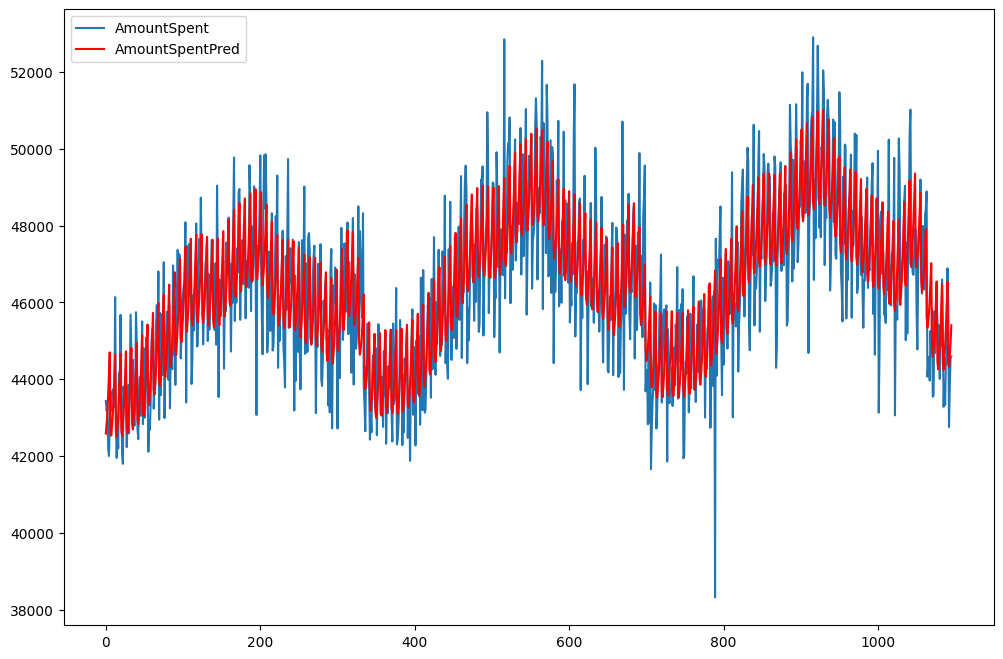

In [56]:
# plotting predictions vs reality
fig, ax = plt.subplots(figsize=(12,8))
df_final['AmountSpent'].plot(ax=ax, legend=('Amount Spent'))
df_final['AmountSpentPred'].plot(ax=ax, color='r', legend={'Predicted'})
plt.savefig('st_yhat.png')
plt.show()


# Conclusão

Após a transformação da série em estacionária, observou-se uma redução nos erros do modelo. O MAE diminuiu de 941 para 935,1086, enquanto o RMSE reduziu de 1219 para 1213,5308. Esses resultados indicam uma leve melhoria no desempenho do modelo após a transformação.